In [2]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
from copy import copy
params = {
   'axes.labelsize': 10,
   'font.size': 10,
   'legend.fontsize': 10,
   'xtick.labelsize': 10,
   'ytick.labelsize': 10,
   'axes.titlesize':10,
   'text.usetex': True,
   'font.family':'serif',
   'font.serif':'Computer Modern'
   }
matplotlib.rcParams.update(params)
matplotlib.rcParams["font.serif"] = "Computer Modern Roman"
matplotlib.rcParams["font.family"] = "Serif"
matplotlib.rcParams['text.latex.preamble'] = r'\renewcommand{\mathdefault}[1][]{}'

from matplotlib.markers import MarkerStyle
import matplotlib as mpl

In [17]:
import GWPhotonCounting
import jax.numpy as jnp


frequencies = jnp.sort(jnp.fft.fftfreq(2**13, d=1/1e4))
detector = GWPhotonCounting.detector.Detector(
    frequencies, '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE_shot_psd_nosqz.csv', 
    '/home/ethan.payne/projects/GWPhotonCounting/examples/data/CE_classical_psd.csv', 
    gamma=15, random_seed=1632, N_frequency_spaces=10)

In [2]:
# import h5py

# data_CE1 = h5py.File('data/traces_CE2silica.h5', 'r')
# freqs = data_CE1['freq'][()]
# shot_psd_nosqz = data_CE1['nosqz'][()]
# shot_psd_sqz = data_CE1['sqz'][()]

# classical_quanta = data_CE1['classical'][()]/(2*shot_psd_nosqz)



# import numpy as np

# np.savetxt('data/CE_shot_psd_nosqz.csv', np.array([freqs, shot_psd_nosqz]).T)
# np.savetxt('data/CE_shot_psd_sqz.csv', np.array([freqs, shot_psd_sqz]).T)
# np.savetxt('data/CE_classical_psd.csv', np.array([freqs, data_CE1['classical'][()]]).T)
# np.savetxt('data/CE_total_psd_sqz.csv', np.array([freqs, shot_psd_sqz+data_CE1['classical'][()]]).T)


# data_CE1.close()

In [3]:
# import h5py

# data_CE1 = h5py.File('data/traces_CE2silicon.h5', 'r')
# freqs = data_CE1['freq'][()]
# shot_psd_nosqz = data_CE1['nosqz'][()]
# shot_psd_sqz = data_CE1['sqz'][()]

# classical_quanta = data_CE1['classical'][()]/(2*shot_psd_nosqz)



# import numpy as np

# np.savetxt('data/CE2silicon_shot_psd.csv', np.array([freqs, shot_psd_nosqz]).T)
# np.savetxt('data/CE2silicon_classical_quanta.csv', np.array([freqs, classical_quanta]).T)
# np.savetxt('data/CE2silicon_sqz_total_psd.csv', np.array([freqs, shot_psd_sqz+data_CE1['classical'][()]]).T)


# data_CE1.close()

In [4]:
LorentzianModel = GWPhotonCounting.signal.PostMergerLorentzian()
KNNModel = GWPhotonCounting.signal.PostMergerKNN(knn_file_path='/home/ethan.payne/code_libraries/apr4_knn_gw_model_2024/KNN_Models/APR4-knn_model-N100')

/home/ethan.payne/.conda/envs/ve310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [8]:


mtot = 2.5
phi0 = 0
z = 0.03
ra = 0.0
dec = 0.3
iota=0.2
psi = 0

# mtots, z, phi, psi, ra, dec, iota, f0_fit, gamma_fit, A_fit, phase_fit, snr, snr_sqz = [
#         2.61818695e+00, 2.08329854e+00, 5.35330329e+00, 2.29492744e+00,
#        3.98733925e+00, 6.17580362e-01, 2.42270780e+00, 1.10137455e+03,
#        1.59427071e+01, 1.40546151e-24, 2.10024603e+00, 1.32405809e-03,
#        3.13480987e-03]

PM_strain = KNNModel.generate_strain(detector, frequencies, mtot, phi0, z, ra, dec, iota, psi)

#PM_strain = LorentzianModel.generate_strain(detector, frequencies, f0_fit, gamma_fit, A_fit, phase_fit, 0)[0]


In [9]:
expected_signal_photon_count = detector.calculate_signal_photon_expectation(PM_strain, frequencies)

In [10]:
print('Optimal SNR', detector.calculate_optimal_snr(PM_strain, frequencies))
print('Expected photon count from SNR', detector.calculate_optimal_snr(PM_strain, frequencies)**2/2)
print('Expected photon count from filters', jnp.sum(expected_signal_photon_count))

Optimal SNR 1.2402993019213908
Expected photon count from SNR 0.7691711791733447
Expected photon count from filters 0.4382661445903035


In [11]:
print(jnp.max(expected_signal_photon_count))

0.08247756241382567


/local/ethan.payne/ipykernel_4175442/352412607.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


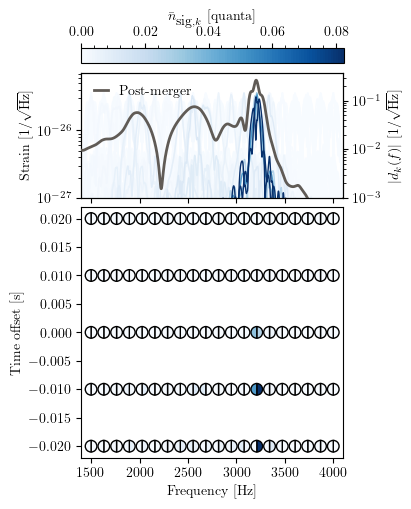

In [12]:
# Make plot for the n_exp_photons 

#fig = GWPhotonCounting.plotting.generate_count_plot((expected_signal_photon_count), detector)

fig = GWPhotonCounting.plotting.generate_count_plot_with_strain(expected_signal_photon_count, detector, frequencies, PM_strain)
#fig = GWPhotonCounting.plotting.generate_count_plot((detector.noise_photon_expectation)*1e3, detector)
fig.tight_layout()

axs = fig.get_axes()

#fig.savefig('photon_counting_switchboard.pdf', bbox_inches='tight')

In [34]:
poisson_likelihood = GWPhotonCounting.distributions.PoissonPhotonLikelihood()

noise_likelihood = GWPhotonCounting.distributions.PhaseQuadraturePhotonLikelihood()

mixture_likelihood = GWPhotonCounting.distributions.MixturePhotonLikelihood(poisson_likelihood, noise_likelihood)

gaussian_likelihood = GWPhotonCounting.distributions.GaussianStrainLikelihood()


In [42]:
observed_photons, observed_signal_photons, observed_noise_photons = \
    mixture_likelihood.generate_realization(
        expected_signal_photon_count, detector.noise_photon_expectation)

# Simulating a photon count
observed_signal_photons = jnp.zeros(len(observed_photons))
observed_signal_photons = observed_photons.at[jnp.argmax(expected_signal_photon_count)].set(1)
observed_noise_photons = jnp.zeros(len(observed_photons))#observed_photons.at[jnp.argmax(detector.noise_photon_expectation)].set(1)
observed_photons = observed_signal_photons + observed_noise_photons

print('Observed photons count: ', jnp.sum(observed_photons))
print(f'Observed signal (noise) photons: {jnp.sum(observed_signal_photons)} ({jnp.sum(observed_noise_photons)})')
print('Expected photon count where observed photons are: ', expected_signal_photon_count[observed_photons > 0])


Observed photons count:  1.0
Observed signal (noise) photons: 1.0 (0.0)
Expected photon count where observed photons are:  [0.0002392]


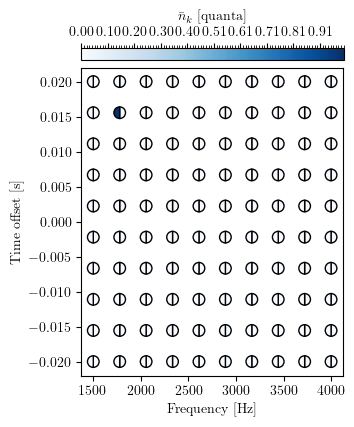

In [43]:
fig = GWPhotonCounting.plotting.generate_count_plot(observed_photons, detector)

In [ ]:
fit_lorentzian_n = GWPhotonCounting.inference.PhotonCountingInference(detector, frequencies, mixture_likelihood).run(
    observed_photons,
    num_warmup=100,
    num_samples=500,
    num_chains=2, time_reconstruction=False, f0min=1500)

fit_lorentzian_n_0d01 = GWPhotonCounting.inference.PhotonCountingInference(detector, frequencies, mixture_likelihood).run(
    observed_photons,
    num_warmup=100,
    num_samples=500,
    num_chains=2, time_reconstruction=False, f0min=1500, noise_scale=0.01)

# fit_lorentzian_n = GWPhotonCounting.inference.PhotonCountingInference(detector, frequencies, poisson_likelihood, include_background=False).run(
#     observed_photons,
#     num_warmup=200,
#     num_samples=1000,
#     num_chains=1)

/home/ethan.payne/projects/GWPhotonCounting/src/GWPhotonCounting/inference.py:97: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
sample:  54%|█████▎    | 322/600 [04:09<03:03,  1.51it/s, 63 steps of size 6.85e-02. acc. prob=0.99]

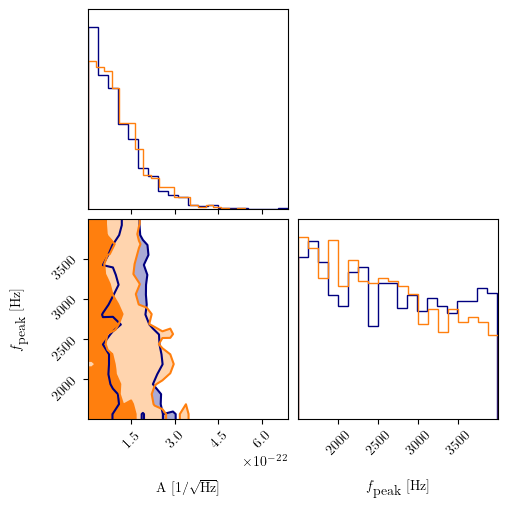

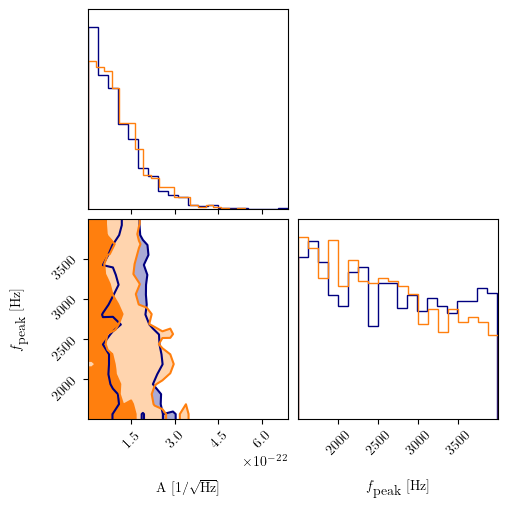

In [ ]:
from corner import corner

fig = corner(fit_lorentzian_n.posterior, plot_datapoints=False, fill_contours=True, plot_density=False, color='navy', levels=[0.5,0.9], smooth=0.7, 
      var_names=['A', 'f0'], labels=[r'A [1/$\sqrt{\textrm{Hz}}$]', r'$f_\textrm{peak}$ [Hz]'], hist_kwargs={'density':True})

corner(fit_lorentzian_n_0d01.posterior, plot_datapoints=False, fill_contours=True, plot_density=False, color='C1', levels=[0.5,0.9], smooth=0.7, 
      var_names=['A', 'f0'], labels=[r'A [1/$\sqrt{\textrm{Hz}}$]', r'$f_\textrm{peak}$ [Hz]'], hist_kwargs={'density':True}, fig=fig)

In [ ]:
observed_strain = PM_strain + gaussian_likelihood.generate_realization(detector_squeeze.total_psd, frequencies)

fit_lorentzian_strain = GWPhotonCounting.inference.StrainInference(detector_squeeze, frequencies, gaussian_likelihood).run(
    observed_strain,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2, time_reconstruction=False, f0min=1.5e3)

/home/ethan.payne/projects/GWPhotonCounting/src/GWPhotonCounting/inference.py:165: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
warmup:  16%|█▌        | 313/2000 [00:37<07:17,  3.86it/s, 63 steps of size 9.94e-02. acc. prob=0.78] 

sample: 100%|██████████| 2000/2000 [03:04<00:00, 10.85it/s, 15 steps of size 2.65e-01. acc. prob=0.88]


2.1131512029732466e-23


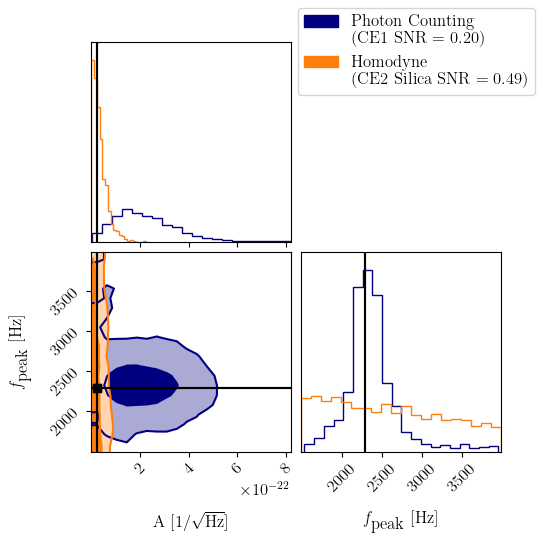

In [ ]:
from corner import corner

fpeak = jnp.abs(frequencies[jnp.argmax(jnp.abs(PM_strain))])

print(A)



fig = corner(fit_lorentzian_n.posterior, plot_datapoints=False, fill_contours=True, plot_density=False, color='navy', levels=[0.5,0.9], smooth=0.7, 
      var_names=['A', 'f0'], labels=[r'A [1/$\sqrt{\textrm{Hz}}$]', r'$f_\textrm{peak}$ [Hz]'], hist_kwargs={'density':True}, truths=[A, fpeak], truth_color='k')

corner(fit_lorentzian_strain.posterior, plot_datapoints=False, fill_contours=True, plot_density=False, color='C1', levels=[0.5,0.9], smooth=0.7, 
      var_names=['A', 'f0'], labels=[r'A [1/$\sqrt{\textrm{Hz}}$]', r'$f_\textrm{peak}$ [Hz]'], hist_kwargs={'density':True}, truths=[A, fpeak], truth_color='k', fig=fig)

legend_labels = [Patch(color='navy', label=r'\noindent Photon Counting \\ (CE1 SNR $ =0.20$)'), Patch(color='C1', label=r'\noindent Homodyne \\ (CE2 Silica SNR $ = 0.49$)')]
fig.legend(handles=legend_labels, loc='upper right', fontsize=12)

fig.savefig('corner_plot.png', dpi=300, bbox_inches='tight')

In [ ]:
from tqdm import tqdm 

lorentzian_fit_strain_array = []
homodyne_lorentzian_fit_strain_array = []

for i in tqdm(range(2000)):
    lorentzian_fit_strain_i = LorentzianModel.generate_strain(
        detector, frequencies, 
        fit_lorentzian_n.posterior.f0.values.flatten()[i], fit_lorentzian_n.posterior.gamma.values.flatten()[i], 
        fit_lorentzian_n.posterior.A.values.flatten()[i], 0, 
        fit_lorentzian_n.posterior.phase.values.flatten()[i])[0,]
    
    homodyne_lorentzian_fit_strain_i = LorentzianModel.generate_strain(
        detector, frequencies, 
        fit_lorentzian_strain.posterior.f0.values.flatten()[i], fit_lorentzian_strain.posterior.gamma.values.flatten()[i], 
        fit_lorentzian_strain.posterior.A.values.flatten()[i], 0, 
        fit_lorentzian_strain.posterior.phase.values.flatten()[i])[0,]
    
    lorentzian_fit_strain_array.append(jnp.abs(lorentzian_fit_strain_i))
    homodyne_lorentzian_fit_strain_array.append(jnp.abs(homodyne_lorentzian_fit_strain_i))

lorentzian_fit_strain_array = jnp.array(lorentzian_fit_strain_array)
homodyne_lorentzian_fit_strain_array = jnp.array(homodyne_lorentzian_fit_strain_array)

100%|██████████| 2000/2000 [00:04<00:00, 468.81it/s]


/local/ethan.payne/ipykernel_3850162/526672060.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


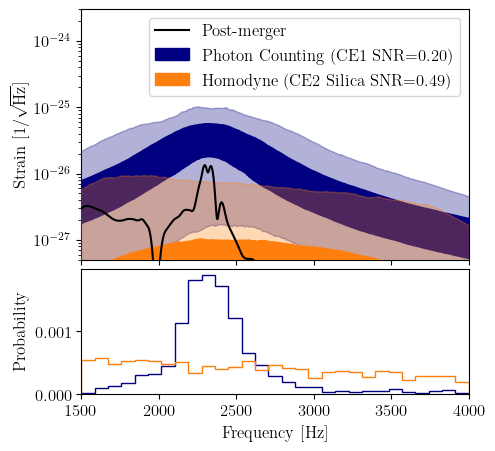

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(5,5), sharex=True, gridspec_kw={'height_ratios': [2, 1], 'hspace':0.05})

ax[0].plot(frequencies, jnp.abs(PM_strain), label='Post-merger', color='k',zorder=100)

# ax[0].plot(frequencies, lorentzian_fit_strain_array[:100].T, label='Photon Counting', color='navy', alpha=0.1)
# ax[0].plot(frequencies, homodyne_lorentzian_fit_strain_array[:100].T, label='Homodyne', color='C1', alpha=0.1)
#ax[0].plot(frequencies, jnp.median(lorentzian_fit_strain_array, axis=0), label='Photon Counting', color='navy')
ax[0].fill_between(frequencies, jnp.percentile(lorentzian_fit_strain_array, 25, axis=0), jnp.percentile(lorentzian_fit_strain_array, 75, axis=0), color='navy', alpha=1,zorder=90,label='Photon Counting (CE1 SNR=0.20)')
ax[0].fill_between(frequencies, jnp.percentile(lorentzian_fit_strain_array, 5, axis=0), jnp.percentile(lorentzian_fit_strain_array, 95, axis=0), color='navy', alpha=0.3,zorder=80)
ax[0].fill_between(frequencies, jnp.zeros(len(frequencies)), jnp.percentile(homodyne_lorentzian_fit_strain_array, 50, axis=0), color='C1', alpha=1,zorder=92,label='Homodyne (CE2 Silica SNR=0.49)')
ax[0].fill_between(frequencies, jnp.zeros(len(frequencies)), jnp.percentile(homodyne_lorentzian_fit_strain_array, 90, axis=0), color='C1', alpha=0.3,zorder=91)

ax[0].set_xlim(1.5e3, 4e3)
ax[0].set_ylim(5e-28,3e-24)

ax[0].legend(loc='upper right')

ax[0].set_yscale('log')

ax[1].hist(fit_lorentzian_n.posterior.f0.values.flatten(), bins=jnp.linspace(1.5e3,4e3,30), histtype='step', color='navy', density=True)
ax[1].hist(fit_lorentzian_strain.posterior.f0.values.flatten(), bins=jnp.linspace(1.5e3,4e3,30), histtype='step', color='C1', density=True)

ax[0].set_ylabel('Strain [$1/\sqrt{\mathrm{Hz}}$]')
ax[1].set_xlabel('Frequency [Hz]')
ax[1].set_ylabel('Probability')

fig.tight_layout()
fig.savefig('strain_comparison.png', dpi=300, bbox_inches='tight')

In [ ]:
GWPhotonCounting.inference.save_analyses('example', fit_strain=fit_lorentzian_strain, outdir='results/',
               snr=float(detector.calculate_optimal_snr(PM_strain, frequencies)), 
               snr_squeeze=float(detector_squeeze.calculate_optimal_snr(PM_strain, frequencies)))

NameError: name 'GWPhotonCounting' is not defined

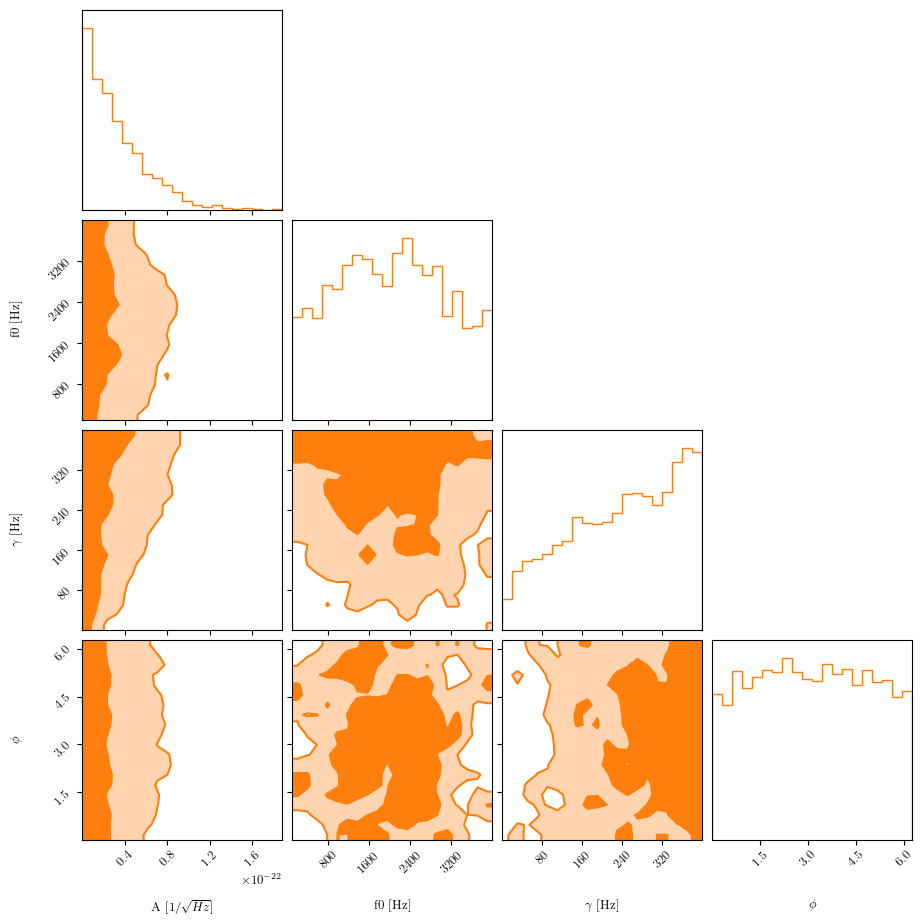

In [ ]:
from corner import corner 
import matplotlib.pyplot as plt

corner(fit_lorentzian_strain.posterior, plot_datapoints=False, fill_contours=True, plot_density=False, color='C1', levels=[0.5,0.9], smooth=0.7, 
      var_names=['A', 'f0', 'gamma', 'phase'], labels=[r'A [1/$\sqrt{Hz}$]', 'f0 [Hz]', r'$\gamma$ [Hz]', r'$\phi$'], 
      hist_kwargs={'density':True}, truths=[None, None, None, None], truth_color='k')

plt.show()